#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [3]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [4]:
data.shape

(45063, 8)

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

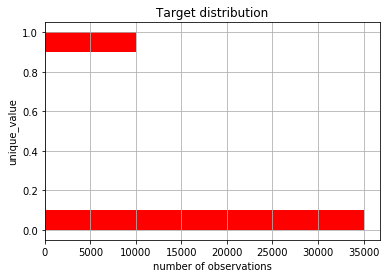

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_title("Target distribution")
ax.set_xlabel("number of observations")
ax.set_ylabel("unique_value")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def replace_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
        
    return table  

In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = replace_nan(data)
table.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [9]:
## Разделяем таргет и признаки 

X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Сделаем интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита с 90% "уверенностью":

In [10]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint( 0, len(data), (n_samples, len(data)) )
    samples = data[indices]
    
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    
    return boundaries

In [11]:
# сохранение в отдельные numpy массивы данных по выплатившим и уже просрочившим клиентам
returned_loan = table[table['SeriousDlqin2yrs'] == 0]['age'].values
overdued_loan = table[table['SeriousDlqin2yrs'] == 1]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
returned_mean_scores = [np.mean(sample) 
                           for sample in get_bootstrap_samples(returned_loan, 1000)]
iverdued_mean_scores = [np.mean(sample) 
                           for sample in get_bootstrap_samples(overdued_loan, 1000)]

#  выводим интервальную оценку среднего
print("Age of clients who returned the loan:  mean interval",  stat_intervals(returned_mean_scores, 0.1))
print("Age of clients who overdued the loan:  mean interval",  stat_intervals(iverdued_mean_scores, 0.1))

Age of clients who returned the loan:  mean interval [52.59069983 52.85581385]
Age of clients who overdued the loan:  mean interval [45.70569021 46.14615001]


---

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error 

In [13]:
## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов

lr = LogisticRegression(random_state=5, class_weight= 'balanced')

In [14]:
# Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии)

parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [15]:
## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Сделаем GridSearch с метрикой "roc-auc" по параметру C:

In [16]:
CV_lr = GridSearchCV(estimator=lr, 
                    param_grid=parameters,
                    scoring='roc_auc',
                    cv=skf)
CV_lr.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [17]:
CV_lr.best_params_

{'C': 0.001}

In [18]:
CV_lr.best_score_

0.8089120626797153

Определим самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нормализуем все признаки, что бы можно их было корректно сравнить:

In [19]:
def normalize(weights):
    weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))
    
    return weights

In [20]:
logreg = LogisticRegression(random_state=5, C=0.001, class_weight='balanced').fit(X, y)

print( "MSE = %.4f" % mean_squared_error(y, logreg.predict(X)) )

MSE = 0.2080


In [21]:
logreg_coefs = []
for i in range(logreg.coef_.shape[0]):
    for j in range(logreg.coef_.shape[1]):
        logreg_coefs.append(logreg.coef_[i][j])

In [22]:
lr_coef = pd.DataFrame({'coefs': logreg_coefs})
lr_coef

,coefs
0,-0.013656
1,0.446832
2,-0.000006
3,0.390381
4,0.216038
5,-0.000011
6,0.191726


In [23]:
logreg_tmp_coefs = normalize(logreg.coef_)

logreg_norm_coefs = []
for i in range(logreg_tmp_coefs.shape[0]):
    for j in range(logreg_tmp_coefs.shape[1]):
        logreg_norm_coefs.append(logreg_tmp_coefs[i][j])

In [24]:
lr_norm_coef = pd.DataFrame({'normalized_coefs': logreg_norm_coefs})
lr_norm_coef

,normalized_coefs
0,0.000000
1,1.000000
2,0.029640
3,0.877409
4,0.498805
5,0.029630
6,0.446009


In [25]:
for i,v in enumerate(logreg_coefs):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.01366
Feature: 1, Score: 0.44683
Feature: 2, Score: -0.00001
Feature: 3, Score: 0.39038
Feature: 4, Score: 0.21604
Feature: 5, Score: -0.00001
Feature: 6, Score: 0.19173


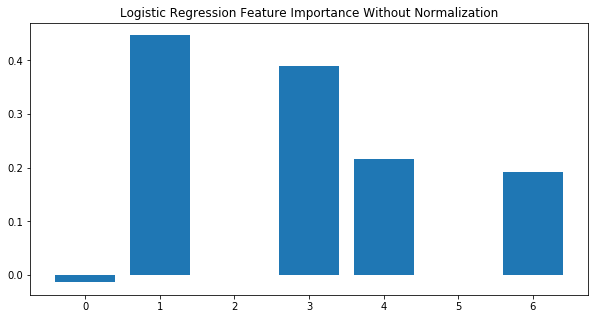

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Logistic Regression Feature Importance Without Normalization")
plt.bar([x for x in range(len(logreg_coefs))], logreg_coefs)
plt.show()

In [27]:
for i,v in enumerate(logreg_norm_coefs):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 1.00000
Feature: 2, Score: 0.02964
Feature: 3, Score: 0.87741
Feature: 4, Score: 0.49881
Feature: 5, Score: 0.02963
Feature: 6, Score: 0.44601


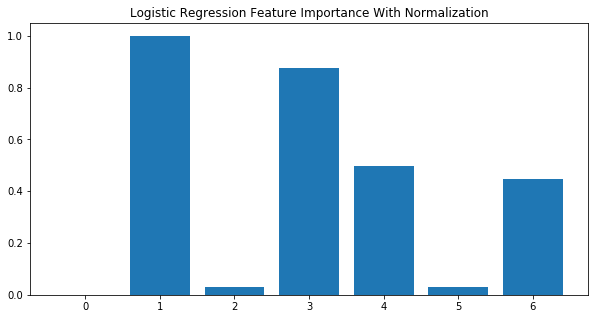

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Logistic Regression Feature Importance With Normalization")
plt.bar([x for x in range(len(logreg_norm_coefs))], logreg_norm_coefs)
plt.show()

In [29]:
data.sample()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
41110,1,54,0,0.361547,0,1,10833.0,2.0


Теперь посчитаем во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков:

In [30]:
logreg = LogisticRegression(random_state=5, C=0.001, class_weight='balanced').fit(X, y)

In [31]:
table['new_age'] = table['age'] + 20
table.head(3)

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents,new_age
0,0,64,0,0.249908,0,0,8158.0,0.0,84
1,0,58,0,3870.000000,0,0,5166.0,0.0,78
2,0,41,0,0.456127,0,0,6666.0,0.0,61


In [32]:
X_tmp = table.drop(columns=['age', 'SeriousDlqin2yrs'])

logreg_tmp = LogisticRegression(random_state=5, C=0.001, class_weight='balanced').fit(X_tmp, y)

In [33]:
print("The probabilities not to return the loan with old ages:", logreg.predict_proba(X))
print()
print("The probabilities not to return the loan with new ages:", logreg_tmp.predict_proba(X_tmp) )

The probabilities not to return the loan with old ages: [[0.70017099 0.29982901]
 [0.68069471 0.31930529]
 [0.62642519 0.37357481]
 ...
 [0.51260066 0.48739934]
 [0.32112496 0.67887504]
 [0.33683888 0.66316112]]

The probabilities not to return the loan with new ages: [[0.68536406 0.31463594]
 [0.67282433 0.32717567]
 [0.6342965  0.3657035 ]
 ...
 [0.52424076 0.47575924]
 [0.3287556  0.6712444 ]
 [0.3441719  0.6558281 ]]


In [34]:
(logreg.predict_proba(X) - logreg_tmp.predict_proba(X_tmp)).mean()

9.23892404488014e-21

In [35]:
from scipy import stats

mode = stats.mode(logreg.predict_proba(X) - logreg_tmp.predict_proba(X_tmp))
mode[0]

array([[0., 0.]])

Разницы, в общем, практически никакой.
<br>По обрывистым массивам выше видим, что данные колеблются в пределах 1го процента.

---

Поработаем со случайным лесом:

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5, 10, 15]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [38]:
CV_rfc = GridSearchCV(estimator=rf, 
                    param_grid=parameters,
                    scoring='roc_auc',
                    cv=skf)
CV_rfc.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [39]:
CV_rfc.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [40]:
CV_rfc.best_score_

0.8357327333345677

У LogReg было:
<br>0.8089120626797153

Определим, какой признак имеет самое слабое влияние:

In [41]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            max_depth=10, max_features=2, min_samples_leaf=9,
                            random_state=42, oob_score=True, 
                            class_weight='balanced')
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, n_jobs=-1, oob_score=True,
                       random_state=42)

In [42]:
importances = rf.feature_importances_
importances

array([0.11558728, 0.30101098, 0.0761183 , 0.27844665, 0.1562167 ,
       0.05827661, 0.01434349])

In [43]:
features = {"f1":u"age",
            "f2":u"NumberOfTime30-59DaysPastDueNotWorse",
            "f3":u"DebtRatio",
            "f4":u"NumberOfTimes90DaysLate",
            "f5":u"NumberOfTime60-89DaysPastDueNotWorse",
            "f6":u"MonthlyIncome",
            "f7":u"NumberOfDependents"}

Feature ranking:
1. NumberOfTime30-59DaysPastDueNotWorse 0.301011 
2. NumberOfTimes90DaysLate 0.278447 
3. NumberOfTime60-89DaysPastDueNotWorse 0.156217 
4. age 0.115587 
5. DebtRatio 0.076118 
6. MonthlyIncome 0.058277 
7. NumberOfDependents 0.014343 


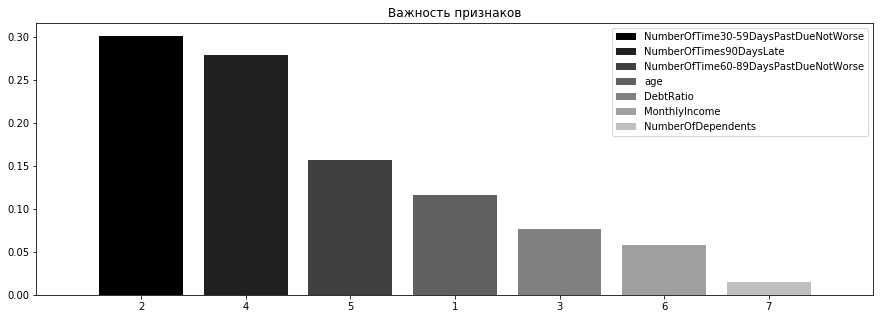

In [44]:
indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 7
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
                            features["f"+str(feature_indices[f])], 
                            importances[indices[f]]
                        ))
    
plt.figure(figsize=(15,5))
plt.title(u"Важность признаков")
plt.xlim([-1, num_to_plot])
ticks = plt.xticks(range(num_to_plot), feature_indices)

bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

Наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи:

* меньше тратится времени для тренировки модели;
* меньше параметров для перебора;
* интепретируемость признаков;
* линейные свойства алгоритма.

---

Перейдем к бэггингу:

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
parameters = {'max_features': [2, 3, 4], 
              'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Обучим бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмем 100 логистических регрессий и на этот раз используем RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставим максимальное число итераций 20 для RandomizedSearchCV:

In [47]:
bc = BaggingClassifier(base_estimator=LogisticRegression(random_state=5, C=0.001, class_weight='balanced'),
                        n_estimators=100, n_jobs=-1, 
                        random_state=42, oob_score=True)

In [48]:
RCV_bc = RandomizedSearchCV(estimator=bc, 
                            param_distributions=parameters,
                            scoring='roc_auc',
                            n_iter=20,
                            cv=skf, random_state=1)
RCV_bc.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(C=0.001,
                                                                                 class_weight='balanced',
                                                                                 random_state=5),
                                               n_estimators=100, n_jobs=-1,
                                               oob_score=True,
                                               random_state=42),
                   n_iter=20,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state

In [49]:
RCV_bc.best_params_

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}

In [50]:
RCV_bc.best_score_

0.8087951623513827

У RandForest было:
<br>0.8357327333345677

У LogReg было: 
<br>0.8089120626797153

Интерпретация лучших параметров для бэггинга:

* для бэггинга важно использовать как можно меньше признаков;
* бэггинг лучше работает на небольших выборках;
* меньше корреляция между одиночными моделями;
* чем больше признаков, тем меньше теряется информации.